# Gradient Boosting

Nós vamos utilizar o dataset Bank Marketing disponibilizado no [site da UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Utilizaremos uma versão adaptada para os objetivos da aula e disponível na pasta `data`.

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, plot_metric, plot_tree, create_tree_digraph
from auto_lgbm import find_n_estimators, grid_search

from sklearn.metrics import log_loss
from evaluation import predictions_hist, confusion_matrix_report, grid_search_report

import shap
import matplotlib.pyplot as plt
import math

/Users/gabrielcs/anaconda/envs/tera-out2018/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sns.set_context("notebook", font_scale=1.5)
shap.initjs()

In [3]:
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

## Preparando os dados

In [4]:
X = df.drop(columns=['month', 'subscribed'])
y = df['subscribed']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)

## Aplicando o Gradient Boosting (implementação da LightGBM)

In [6]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=0)

In [7]:
lgbm.fit(X_train, y_train)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]

In [8]:
y_pred_proba[:5]

array([2.37830543e-04, 3.63669124e-02, 3.73997758e-01, 1.67239322e-02,
       2.88760834e-02])

### Avaliando o modelo

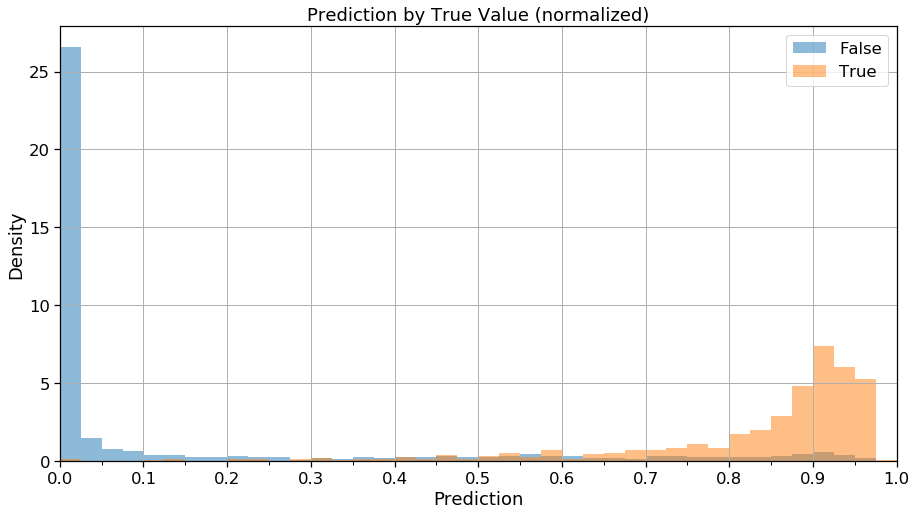

In [9]:
_ = predictions_hist(y_pred_proba, y_test, density=True)

             precision    recall  f1-score   support

      False       0.98      0.89      0.94      7315
       True       0.51      0.89      0.65       922

avg / total       0.93      0.89      0.90      8237



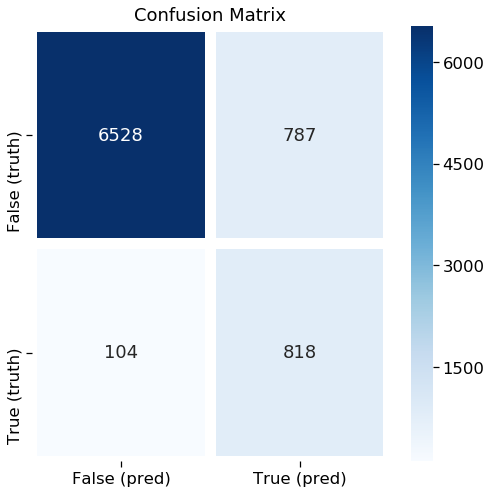

In [10]:
confusion_matrix_report(y_test, y_pred_proba, thres=0.625)

In [11]:
log_loss(y_test, y_pred_proba)

0.2785682008919767

### Visualização de árvores da LightGBM

In [12]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

Nós podemos ver acima que o nosso modelo foi treinado com `n_estimators=100` e `num_leaves=31`. Ou seja, o modelo compreende de 100 árvores de decisão, cada uma com até 31 folhas. Vamos plotar as 2 primeiras.

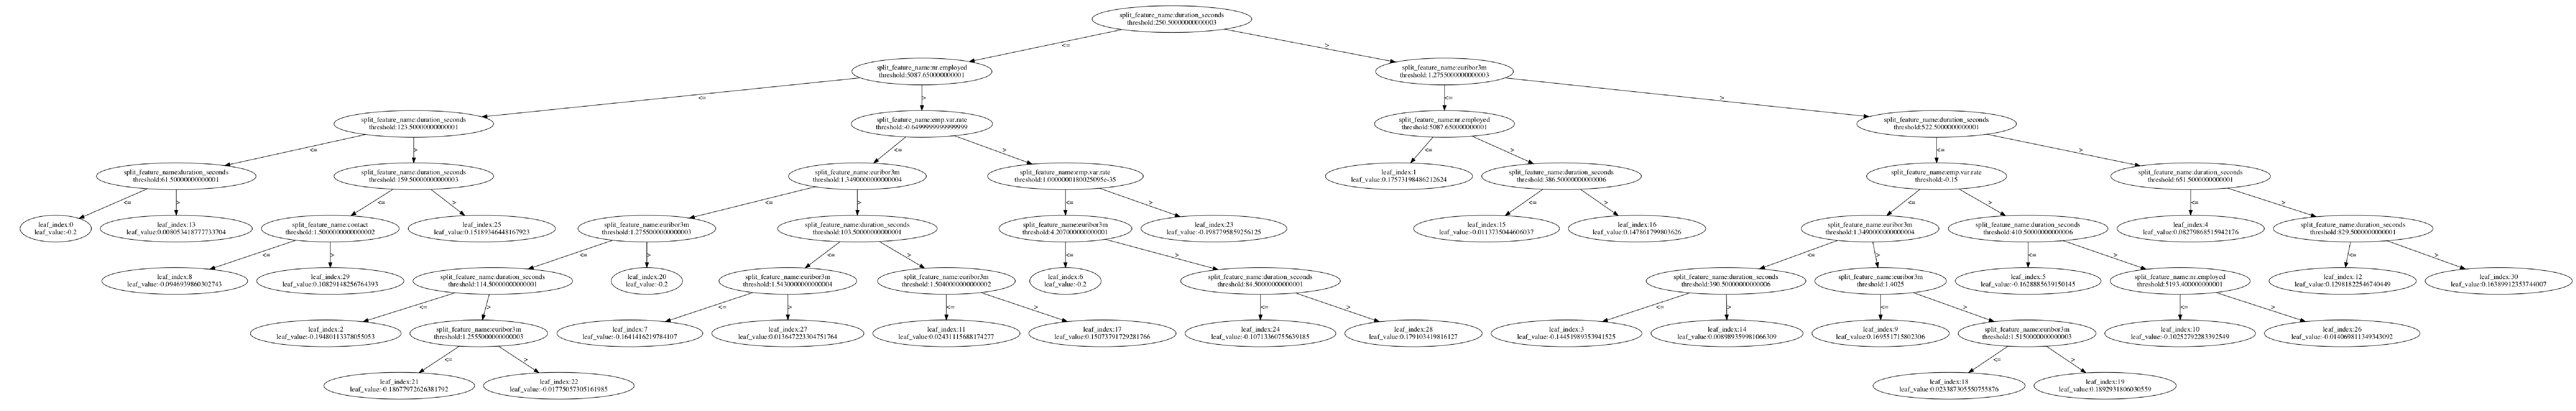

In [13]:
# create_tree_digraph(lgbm, tree_index=0)
_ = plot_tree(lgbm, tree_index=0, figsize=(150, 50))

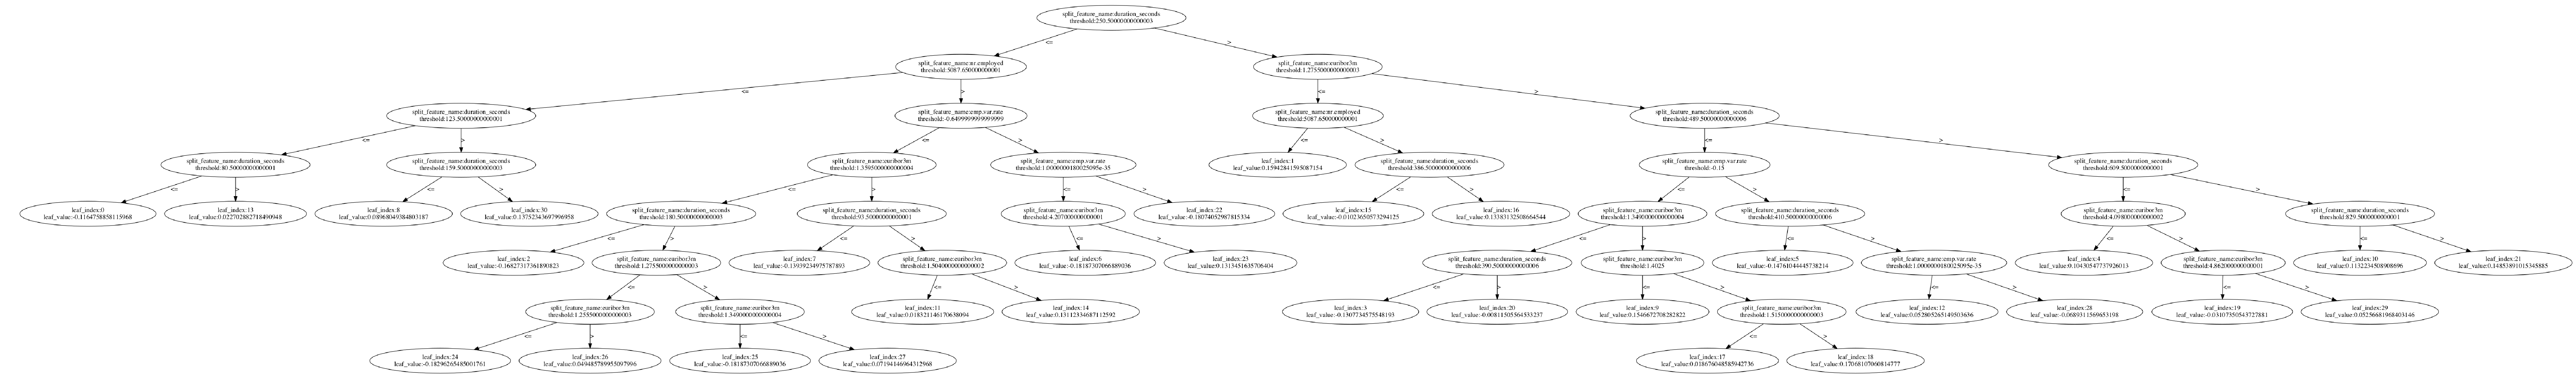

In [14]:
# create_tree_digraph(lgbm, tree_index=1)
_ = plot_tree(lgbm, tree_index=1, figsize=(150, 50))

## Modelando com features categóricas e early stopping

In [15]:
df.dtypes

duration_seconds      int64
duration_minutes    float64
duration_hours      float64
emp.var.rate        float64
nr.employed         float64
euribor3m           float64
month                object
contact               int64
loan                  int64
subscribed             bool
dtype: object

In [16]:
df['month'] = df['month'].astype('category')

In [17]:
X_cat = df.drop(columns=['subscribed'])

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, 
                                                                    random_state=0)

Para o early stopping, vamos quebrar o dataset de treino, que representa 80% dos dados, entre `dev` e `val`, de forma de `dev` fique com 60% dos dados e `val` com 20%.

In [18]:
validation_size = 0.25

X_dev, X_val, y_dev, y_val = train_test_split(X_train_cat, y_train_cat, 
                                              test_size=validation_size, 
                                              random_state=0)

In [19]:
lgbm_es = LGBMClassifier(n_estimators=3000,
                         class_weight='balanced', random_state=0)

In [20]:
_ = lgbm_es.fit(X_dev, y_dev, eval_set=(X_val, y_val),
                early_stopping_rounds=50)

[1]	valid_0's binary_logloss: 0.631996
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.582628
[3]	valid_0's binary_logloss: 0.542288
[4]	valid_0's binary_logloss: 0.50829
[5]	valid_0's binary_logloss: 0.48012
[6]	valid_0's binary_logloss: 0.456214
[7]	valid_0's binary_logloss: 0.435905
[8]	valid_0's binary_logloss: 0.418744
[9]	valid_0's binary_logloss: 0.404
[10]	valid_0's binary_logloss: 0.39115
[11]	valid_0's binary_logloss: 0.380302
[12]	valid_0's binary_logloss: 0.371015
[13]	valid_0's binary_logloss: 0.363205
[14]	valid_0's binary_logloss: 0.356184
[15]	valid_0's binary_logloss: 0.350041
[16]	valid_0's binary_logloss: 0.344405
[17]	valid_0's binary_logloss: 0.339631
[18]	valid_0's binary_logloss: 0.335269
[19]	valid_0's binary_logloss: 0.331904
[20]	valid_0's binary_logloss: 0.328489
[21]	valid_0's binary_logloss: 0.325775
[22]	valid_0's binary_logloss: 0.323223
[23]	valid_0's binary_logloss: 0.320757
[24]	valid_0's binary_logloss: 0.

In [21]:
y_pred_proba_es = lgbm_es.predict_proba(X_test_cat)[:, 1]

In [22]:
log_loss(y_test_cat, y_pred_proba_es)

0.26152543070029066

## Tunando o parâmetro `max_depth` também

In [23]:
max_n_estimators = 3000
early_stopping_rounds = 50
max_depths = range(10, 23)

In [24]:
lgbm_md = LGBMClassifier(n_estimators=max_n_estimators, 
                         class_weight='balanced', random_state=0)

In [25]:
results = pd.DataFrame(columns=['max_depth', 'best_n_estimators', 'best_log_loss'])

for max_depth in tqdm(max_depths):
    lgbm_md.max_depth = max_depth
    
    lgbm_md.fit(X_dev, y_dev, eval_set=(X_val, y_val), 
                early_stopping_rounds=early_stopping_rounds, verbose=False)
    
    results = results.append({'max_depth': max_depth, 
                              'best_n_estimators': lgbm_md.best_iteration_,
                              'best_log_loss': lgbm_md.best_score_['valid_0']['binary_logloss']},
                             ignore_index=True)

100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


In [26]:
results['max_depth'] = results['max_depth'].astype(int)
results['best_n_estimators'] = results['best_n_estimators'].astype(int)

results

,max_depth,best_n_estimators,best_log_loss
0,10,300,0.288844
1,11,325,0.286694
2,12,266,0.286768
3,13,186,0.289281
4,14,306,0.286143
5,15,260,0.286608
6,16,349,0.286805
7,17,389,0.286573
8,18,259,0.287837
9,19,321,0.286910


### Grid search com os melhores conjuntos de parâmetros

In [27]:
param_grids = [
    {'max_depth': [11], 'n_estimators': [325]},
    {'max_depth': [12], 'n_estimators': [266]},
    {'max_depth': [14], 'n_estimators': [306]},
    {'max_depth': [15], 'n_estimators': [260]},
    {'max_depth': [16], 'n_estimators': [349]},
    {'max_depth': [17], 'n_estimators': [389]},
    {'max_depth': [19], 'n_estimators': [321]},
    {'max_depth': [20], 'n_estimators': [319]},
]

In [28]:
scoring = 'neg_log_loss'

In [29]:
grid_search_cv = GridSearchCV(lgbm_md, param_grids, scoring=scoring, 
                           cv=3, verbose=2)

In [30]:
grid_search_cv.fit(X_train_cat, y_train_cat, verbose=False)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=11, n_estimators=325 ..................................
[CV] ................... max_depth=11, n_estimators=325, total=   0.8s
[CV] max_depth=11, n_estimators=325 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ................... max_depth=11, n_estimators=325, total=   0.8s
[CV] max_depth=11, n_estimators=325 ..................................
[CV] ................... max_depth=11, n_estimators=325, total=   0.7s
[CV] max_depth=12, n_estimators=266 ..................................
[CV] ................... max_depth=12, n_estimators=266, total=   0.6s
[CV] max_depth=12, n_estimators=266 ..................................
[CV] ................... max_depth=12, n_estimators=266, total=   0.6s
[CV] max_depth=12, n_estimators=266 ..................................
[CV] ................... max_depth=12, n_estimators=266, total=   0.6s
[CV] max_depth=14, n_estimators=306 ..................................
[CV] ................... max_depth=14, n_estimators=306, total=   0.7s
[CV] max_depth=14, n_estimators=306 ..................................
[CV] ................... max_depth=14, n_estimators=306, total=   0.7s
[CV] max_depth=14, n_estimators=306 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   26.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=22,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [11], 'n_estimators': [325]}, {'max_depth': [12], 'n_estimators': [266]}, {'max_depth': [14], 'n_estimators': [306]}, {'max_depth': [15], 'n_estimators': [260]}, {'max_depth': [16], 'n_estimators': [349]}, {'max_depth': [17], 'n_estimators': [389]}, {'max_depth': [19], 'n_estimators': [321]}, {'max_depth': [20], 'n_estimators': [319]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=2)

In [31]:
grid_search_report(grid_search_cv.grid_scores_, scoring, scoring_alias='log_loss')

/Users/gabrielcs/anaconda/envs/tera-out2018/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,mean_log_loss,std,n_estimators,max_depth
5,0.283489,0.009388,389,17
6,0.283630,0.009117,321,19
1,0.283679,0.008364,266,12
4,0.283700,0.009311,349,16
0,0.283712,0.008980,325,11
3,0.283814,0.008281,260,15
2,0.283825,0.007633,306,14
7,0.283951,0.009024,319,20


In [32]:
grid_search_cv.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=17,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=389, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [33]:
lgbm_md_best = grid_search_cv.best_estimator_

In [34]:
y_pred_proba_md = lgbm_md_best.predict_proba(X_test_cat)[:, 1]
log_loss(y_test_cat, y_pred_proba_md)

0.2634040574118479

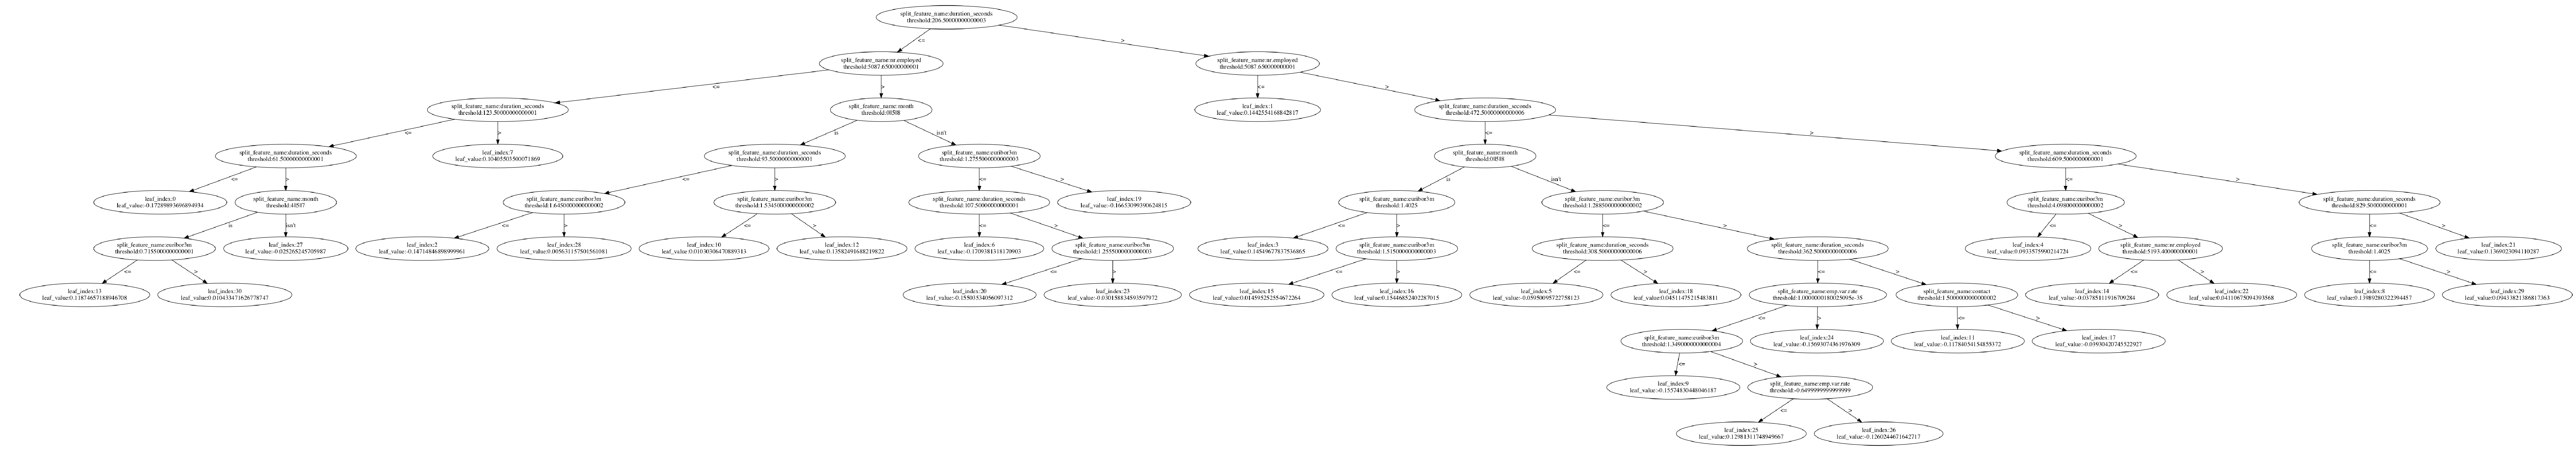

In [35]:
# create_tree_digraph(lgbm, tree_index=2)
_ = plot_tree(lgbm_md_best, tree_index=2, figsize=(150, 50))

## Incluindo tunagem do parâmetro `learning_rate`

In [36]:
lgbm_lr = LGBMClassifier(class_weight='balanced', verbose=-1)

In [37]:
n_estimators_result = find_n_estimators(lgbm_lr, X_train_cat, y_train_cat,
                                        eval_metric='binary_logloss',
                                        learning_rates = [0.01, 0.03, 0.1],
                                        max_depths = range(12, 23),
                                        random_state=0)

learning rates: 100%|██████████| 3/3 [02:35<00:00, 51.89s/it]


In [38]:
n_estimators_result.sort_values(by='best_score').head(10)

,learning_rate,max_depth,best_score,best_n_estimators
4,0.01,16,0.284236,3855
2,0.01,14,0.284436,4115
1,0.01,13,0.285063,3508
5,0.01,17,0.285522,3413
3,0.01,15,0.285618,3585
6,0.01,18,0.285719,3138
10,0.01,22,0.285749,3768
30,0.10,20,0.285757,319
19,0.03,20,0.286041,1070
22,0.10,12,0.286134,352


In [39]:
param_grids = [
    {'learning_rate': [0.01], 'max_depth': [16], 'n_estimators': [3855]}, 
    {'learning_rate': [0.03], 'max_depth': [20], 'n_estimators': [1070]}, 
    {'learning_rate': [0.1], 'max_depth': [20], 'n_estimators': [319]}
]

In [40]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1], 
    'max_depth': [16, 20], 
    'n_estimators': [319, 1070, 3855]
}

In [41]:
grid_search_result, lgbm_lr_best = grid_search(lgbm_lr, X_train_cat, y_train_cat, 
                                               param_grids, scoring='neg_log_loss',
                                               scoring_alias='log_loss')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] learning_rate=0.01, max_depth=16, n_estimators=3855 .............
[CV]  learning_rate=0.01, max_depth=16, n_estimators=3855, total=   8.7s
[CV] learning_rate=0.01, max_depth=16, n_estimators=3855 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=16, n_estimators=3855, total=   9.3s
[CV] learning_rate=0.01, max_depth=16, n_estimators=3855 .............
[CV]  learning_rate=0.01, max_depth=16, n_estimators=3855, total=   8.4s
[CV] learning_rate=0.03, max_depth=20, n_estimators=1070 .............
[CV]  learning_rate=0.03, max_depth=20, n_estimators=1070, total=   2.1s
[CV] learning_rate=0.03, max_depth=20, n_estimators=1070 .............
[CV]  learning_rate=0.03, max_depth=20, n_estimators=1070, total=   2.1s
[CV] learning_rate=0.03, max_depth=20, n_estimators=1070 .............
[CV]  learning_rate=0.03, max_depth=20, n_estimators=1070, total=   2.1s
[CV] learning_rate=0.1, max_depth=20, n_estimators=319 ...............
[CV]  learning_rate=0.1, max_depth=20, n_estimators=319, total=   0.7s
[CV] learning_rate=0.1, max_depth=20, n_estimators=319 ...............
[CV]  learning_rate=0.1, max_depth=20, n_estimators=319, total=   0.7s
[CV] learning_rate=0.1, max_depth=20, n_estimators=319 ............

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   54.2s finished
/Users/gabrielcs/anaconda/envs/tera-out2018/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [42]:
grid_search_result

,mean_log_loss,std,n_estimators,learning_rate,max_depth
0,0.282771,0.008601,3855,0.01,16
1,0.282849,0.008755,1070,0.03,20
2,0.283951,0.009024,319,0.10,20


In [43]:
lgbm_lr_best

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.01, max_depth=16,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=3855, n_jobs=-1, num_leaves=31, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1,
        verbose=-1)

In [44]:
y_pred_proba_lr = lgbm_lr_best.predict_proba(X_test_cat)[:, 1]
log_loss(y_test_cat, y_pred_proba_lr)

0.2629812623289853

## Interpretando o modelo

Para interpretar o modelo, utilizaremos o [SHAP](https://github.com/slundberg/shap).

Para não despendermos muito tempo calculando os SHAP values, utilizaremos uma amostra aleatória de 100 exemplos:

In [45]:
X_train_sample = X_train_cat.sample(1_000, random_state=0)

O `TreeExplainer`, ao contrário do `KernelExplainer` que é genérico, é otimizado para modelos baseados em árvores e tem suporte à LightGBM.

In [46]:
explainer = shap.TreeExplainer(lgbm_lr_best, data=X_train_sample)
shap_values = explainer.shap_values(X_train_sample)

Com os SHAP values calculados, vamos plotar os feature importances:

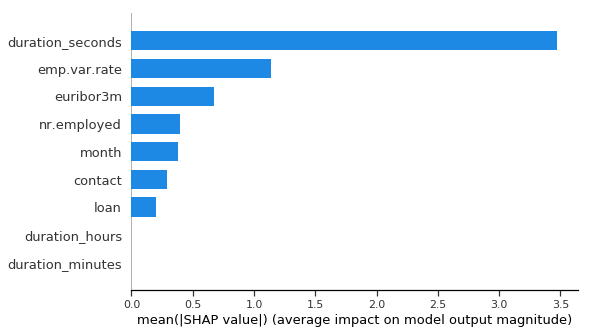

In [47]:
shap.summary_plot(shap_values, X_train_sample, plot_type='bar')

Modifique o parâmetro `plot_type='bar'` para `plot_type='dot'`. Veja que agora é possível fazer uma análise mais aprofundada com o summary plot:

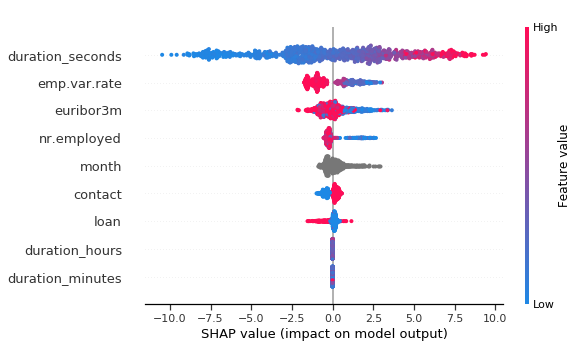

In [48]:
shap.summary_plot(shap_values, X_train_sample, plot_type='dot')

### Vamos dar um deep dive em algumas features

Pense no `dependence_plot` como um zoom que nós podemos dar para entender o que o modelo aprendeu com relação a uma feature específica:

In [49]:
def dependence_plot(feature, show=True):
    shap.dependence_plot(feature, shap_values, X_train_sample, 
                         interaction_index=feature, show=show)

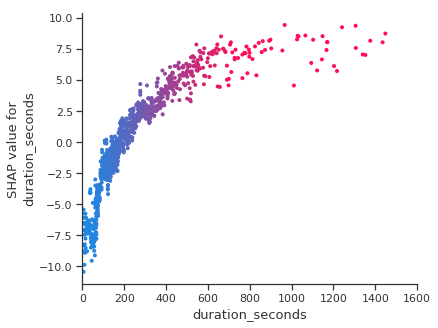

In [50]:
# show=False e o xlim na linha de baixo é para não exibirmos outliers
dependence_plot('duration_seconds', show=False)
_ = plt.xlim(0, 1600)

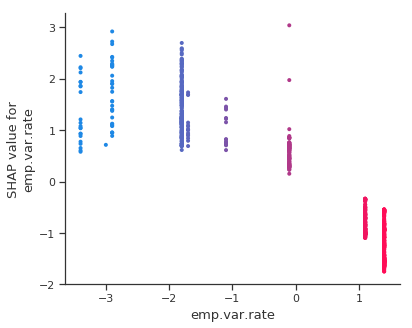

In [51]:
dependence_plot('emp.var.rate')

O nome `dependence plot` é dado ao fato de que o SHAP automaticamente identifica qual é a variável que mais interage com a variável em questão e exibe o seu comportamento dependendo dessa outra variável.

O parâmetro `interaction_index` nos permite selecionar qualquer outra variável para essa comparação. O SHAP é uma ferramenta poderosa, mas ainda é recente e não tem suporte à features categóricas, assim como tem a LightGBM. Dessa forma, setamos o `interaction_index` para a própria feature, de forma a não dar erro.

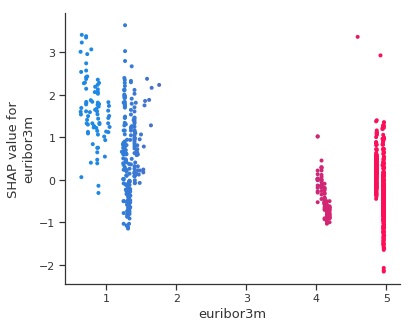

In [52]:
dependence_plot('euribor3m')

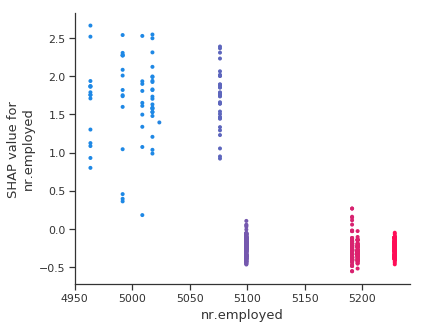

In [53]:
dependence_plot('nr.employed')

### Extra: vamos analisar algumas predições

In [54]:
def logistic(x):
    return math.exp(x) / (math.exp(x) + 1)

In [55]:
explainer.expected_value, logistic(explainer.expected_value)

(-5.461621140758072, 0.004228707810099529)

_Obs.: os plots abaixo podem não ser renderizados pelo GitHub ou em versões antigas do Jupyter Lab._

In [56]:
def force_plot(id_):
    return shap.force_plot(explainer.expected_value, shap_values[id_, :], 
                           X_train_sample.iloc[id_, :])

In [57]:
force_plot(id_=0)

In [58]:
logistic(-8.84)

0.00014480177609174985

In [59]:
force_plot(id_=1)

In [60]:
logistic(1.6)

0.8320183851339245